In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
nltk.download("punkt")
nltk.download("wordnet")
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.metrics import precision_score,recall_score,classification_report,accuracy_score,f1_score,confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
data = pd.read_csv("spam.csv",encoding = 'latin-1')

In [3]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
#Droping some columns
col_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[col_drop], axis=1)
#Renaming the columns
data.rename(columns = {"v1":"Target","v2":"Text"}, inplace = True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# **Data Exploration :**

<Axes: xlabel='Target', ylabel='count'>

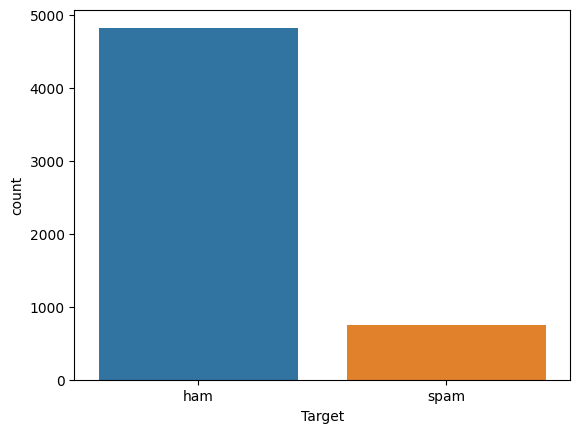

In [6]:
# visualizing the number of ham and spam text
sns.countplot(x= "Target",data=data)

In [7]:
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_words"] = data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis = 1).apply(len)
data["No_of_sentence"] = data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis = 1).apply(len)

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


<Figure size 1200x800 with 0 Axes>

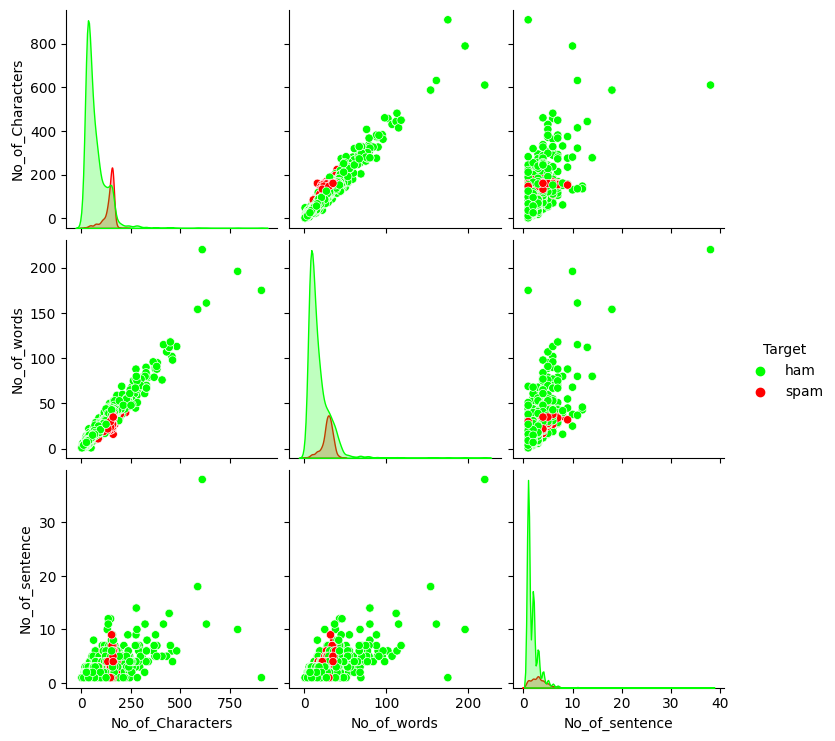

In [22]:
cols = ["#00FF00" , "#Ff0000"]
plt.figure(figsize =(12,8))
fg = sns.pairplot(data = data ,hue = "Target" , palette= cols)
plt.show(fg)

In [23]:
# Outlier detection
data = data[(data["No_of_Characters"]<350)]
data.shape

(5548, 5)

<Figure size 1200x800 with 0 Axes>

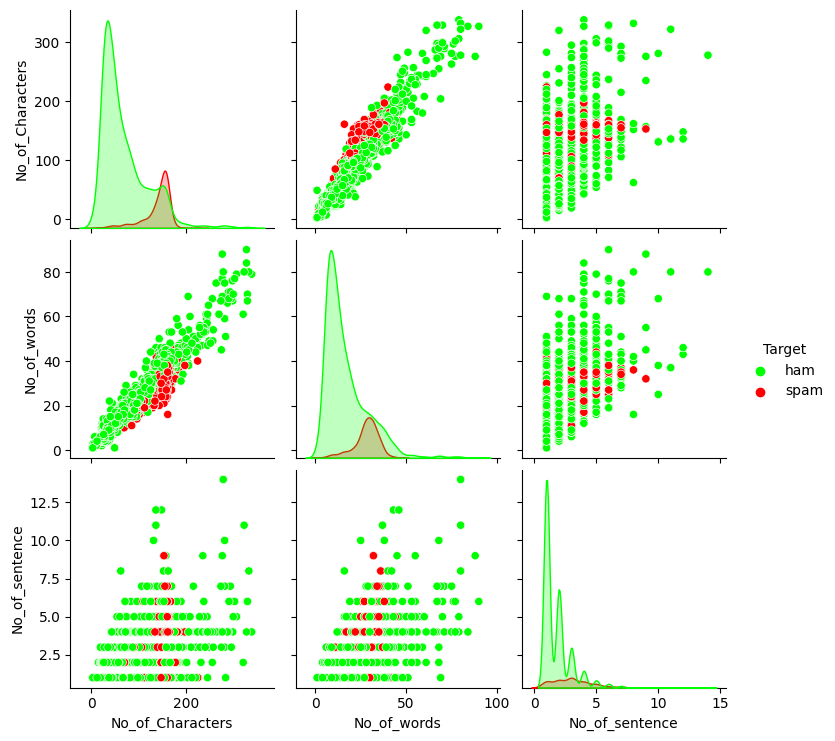

In [24]:
plt.figure(figsize =(12,8))
fg = sns.pairplot(data = data,hue = "Target",palette = cols)
plt.show(fg)

# **Data Preprocessing**

In [25]:
def Clean(Text):
  sms = re.sub('[^a-zA-Z]',' ',Text)
  sms = sms.lower()
  sms = sms.split()
  sms = ' '.join(sms)
  return(sms)
data["Clean_Text"] = data["Text"].apply(Clean)
print("\033[lm\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*data["Clean_Text"][:5],sep = "\n")

m The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


<ipython-input-25-a9c7cbed821d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Clean_Text"] = data["Text"].apply(Clean)


In [26]:
# Tokenization
data["Tokenize_Text"] = data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]),axis =1)
print("\033[lm\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*data["Tokenize_Text"][:5],sep = "\n")

m The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


<ipython-input-26-612f8a325b55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Tokenize_Text"] = data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]),axis =1)


In [29]:
# Removing stopwords
nltk.download('stopwords')
def remove_stopwords(text):
  stop_words = set(stopwords.words("english"))
  filtered_text = [word for word in text if word not in stop_words]
  return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)
print("\033[lm\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5],sep = "\n")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


m The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


In [30]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
  lemmas = [lemmatizer.lemmatize(word , pos="v") for word in text]
  return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[lm\u001b[45;1m The First 5 Texts after Lemmatization:\033[0m",*data["Lemmatized_Text"][:5],sep = "\n")

m The First 5 Texts after Lemmatization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


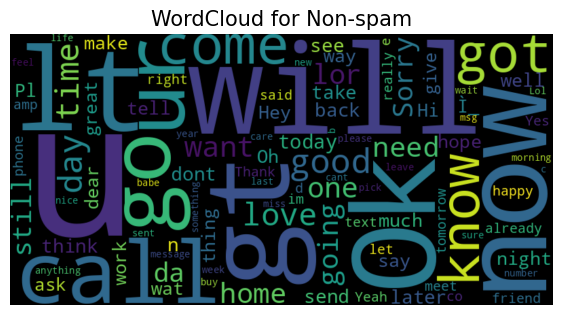

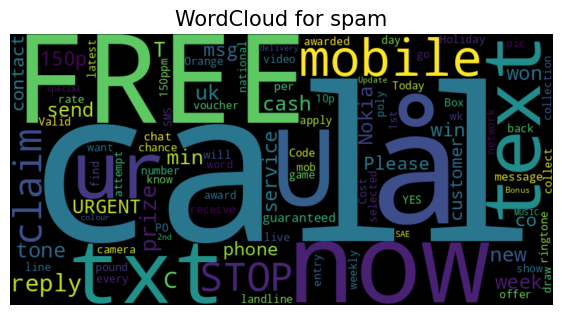

In [31]:
# Visualizing the most frequent words in both ham and spam text
def wordclouds(data,type):
  text = " ".join(data["Text"])
  plt.figure(figsize=(7,7))
  wc = WordCloud(background_color='black',max_words = 100,width = 800,height=400,collocations=False).generate(text)
  plt.imshow(wc, interpolation='bilinear')
  plt.title(f'WordCloud for {type}', fontsize=15)
  plt.axis('off')
  plt.show()

wordclouds(data[data['Target']=='ham'], type='Non-spam')
wordclouds(data[data['Target']=='spam'], type='spam')

In [32]:
# Vectorize

corpus = []
for i in data["Lemmatized_Text"]:
  msg = ' '.join([row for row in i])
  corpus.append(msg)

corpus[:5]
print("\033[lm\u001b[45;1m The First 5 lines in corpus:\033[0m",*corpus[:5],sep = "\n")

m The First 5 lines in corpus:
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [33]:
# changing text data into numerical form
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
X.dtype

dtype('float64')

In [34]:
# Label Encoding
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

# **Model Building**

Build a model for 4 different classifiers



1.   Naive Bayes Classifier
2.   KNeighbors Classifier

1.   RandomForest Classifier
2.   Support Vector Machine

In [36]:
y = data["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [37]:
classifiers = [MultinomialNB(),
               KNeighborsClassifier(),
               RandomForestClassifier(),
               SVC()]
for cls in classifiers:
  cls.fit(X_train,y_train)

pipe_dict = {0: "NaiveBayes", 1: "KNeighbors", 2: "RandomForest", 3: "SVC"}

In [38]:
# cross validation
for i ,model in enumerate(classifiers):
  cv_score = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=10)
  print("%s: %f " %(pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.967552 
KNeighbors: 0.911450 
RandomForest: 0.975664 
SVC: 0.974086 


In [39]:
# Evaluation
precision = []
recall = []
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers :
  pred_train = i.predict(X_train)
  pred_test = i.predict(X_test)
  prec = metrics.precision_score(y_test, pred_test)
  recal = metrics.recall_score(y_test, pred_test)
  f1_s = metrics.f1_score(y_test, pred_test)
  train_accuracy = model.score(X_train, y_train)
  test_accuracy = model.score(X_test, y_test)

  precision.append(prec)
  recall.append(recal)
  f1_score.append(f1_s)
  trainset_accuracy.append(train_accuracy)
  testset_accuracy.append(test_accuracy)

In [40]:
data = {'Precision': precision,
        'Recall': recall,
        'F1score': f1_score,
        'Accuracy on Testset': testset_accuracy,
        'Accuracy on Trainset': trainset_accuracy}
Results = pd.DataFrame(data, index = ["NaiveBayes", "KNeighbors", "RandomForest", "SVC"])

In [41]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap = cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1.000000,0.705882,0.827586,0.974775,0.997521
KNeighbors,0.977778,0.323529,0.486188,0.974775,0.997521
RandomForest,1.000000,0.808824,0.894309,0.974775,0.997521
SVC,0.990909,0.801471,0.886179,0.974775,0.997521
